<font size="4"> <b> • DOMAIN: </b>Entertainment</font>

<font size="4"> <b> • CONTEXT: </b> Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.

<font size="4"> <b> • DATA DESCRIPTION: </b>The dataset comprises of images and its mask where there is a human face.



<font size="4"> <b> • PROJECT OBJECTIVE: </b> Face detection from training images.

<b>Steps and tasks: [ Total Score: 30 Marks]</b>
    
<b>1. Import the dataset</b>

<b>2. Create features (images) and labels (mask) using that data.</b>

<b>3. Mask detection model</b>

>A. Design a face mask detection model. 
    
><i>Hint: Use U-net along with pre-trained transfer learning models</i>    

>B. Design your own Dice Coefficient and Loss function.

>C. Train, tune and test the model

>D. Evaluate the model using testing data
    
<b>4. Use the “Prediction image” as an input to your designed model and display the output of the image</b>

 </font>


<font size="5"><p style="color:black"> <b>1. Import the dataset </p></font>

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import load_npz
import cv2

import os
import re
import natsort
from tqdm import tqdm
from glob import glob
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split, KFold

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = np.load('/content/drive/MyDrive/Colab Notebooks/Part 1- Train data - images.npy', allow_pickle =True)

In [4]:
data.shape

(409, 2)

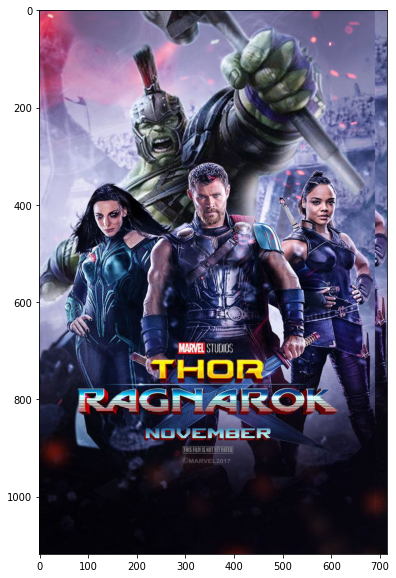

In [5]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(data[32][0])

<font size="5"><p style="color:black"> <b>2. Create features (images) and labels (mask) using that data. </p></font>



Creating masks and images with empty matrix

In [6]:
from tensorflow.keras.applications.mobilenet import preprocess_input
masks = np.zeros((409,  128, 128), dtype=np.float32)
images = images = np.zeros((409, 128, 128, 3), dtype=np.float32)
print('Images:',images.shape,'\n\n','Masks:',masks.shape)

Images: (409, 128, 128, 3) 

 Masks: (409, 128, 128)


In [7]:
# Generating the image array and increasing the dimension of dataset
for i in range(data.shape[0]):
    img = data[i][0]
    img = cv2.resize(img, dsize = ( 128,  128), interpolation = cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    images[i] = preprocess_input(np.array(img, dtype = np.float32))

  # normalizing the bounding boxes 
    for j in data[i][1]:
        x1 = int(j['points'][0]['x'] *  128)
        x2 = int(j['points'][1]['x'] *  128)
        y1 = int(j['points'][0]['y'] *  128)
        y2 = int(j['points'][1]['y'] *  128)
        masks[i][y1:y2, x1:x2] = 1

In [8]:
images.shape

(409, 128, 128, 3)

In [9]:
masks.shape

(409, 128, 128)

Generating 15 images for Images and Masks

In [10]:
def random(n):
    for i in range(0,15):
        plt.subplot(5, 5, i + 1)
        plt.imshow(n[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

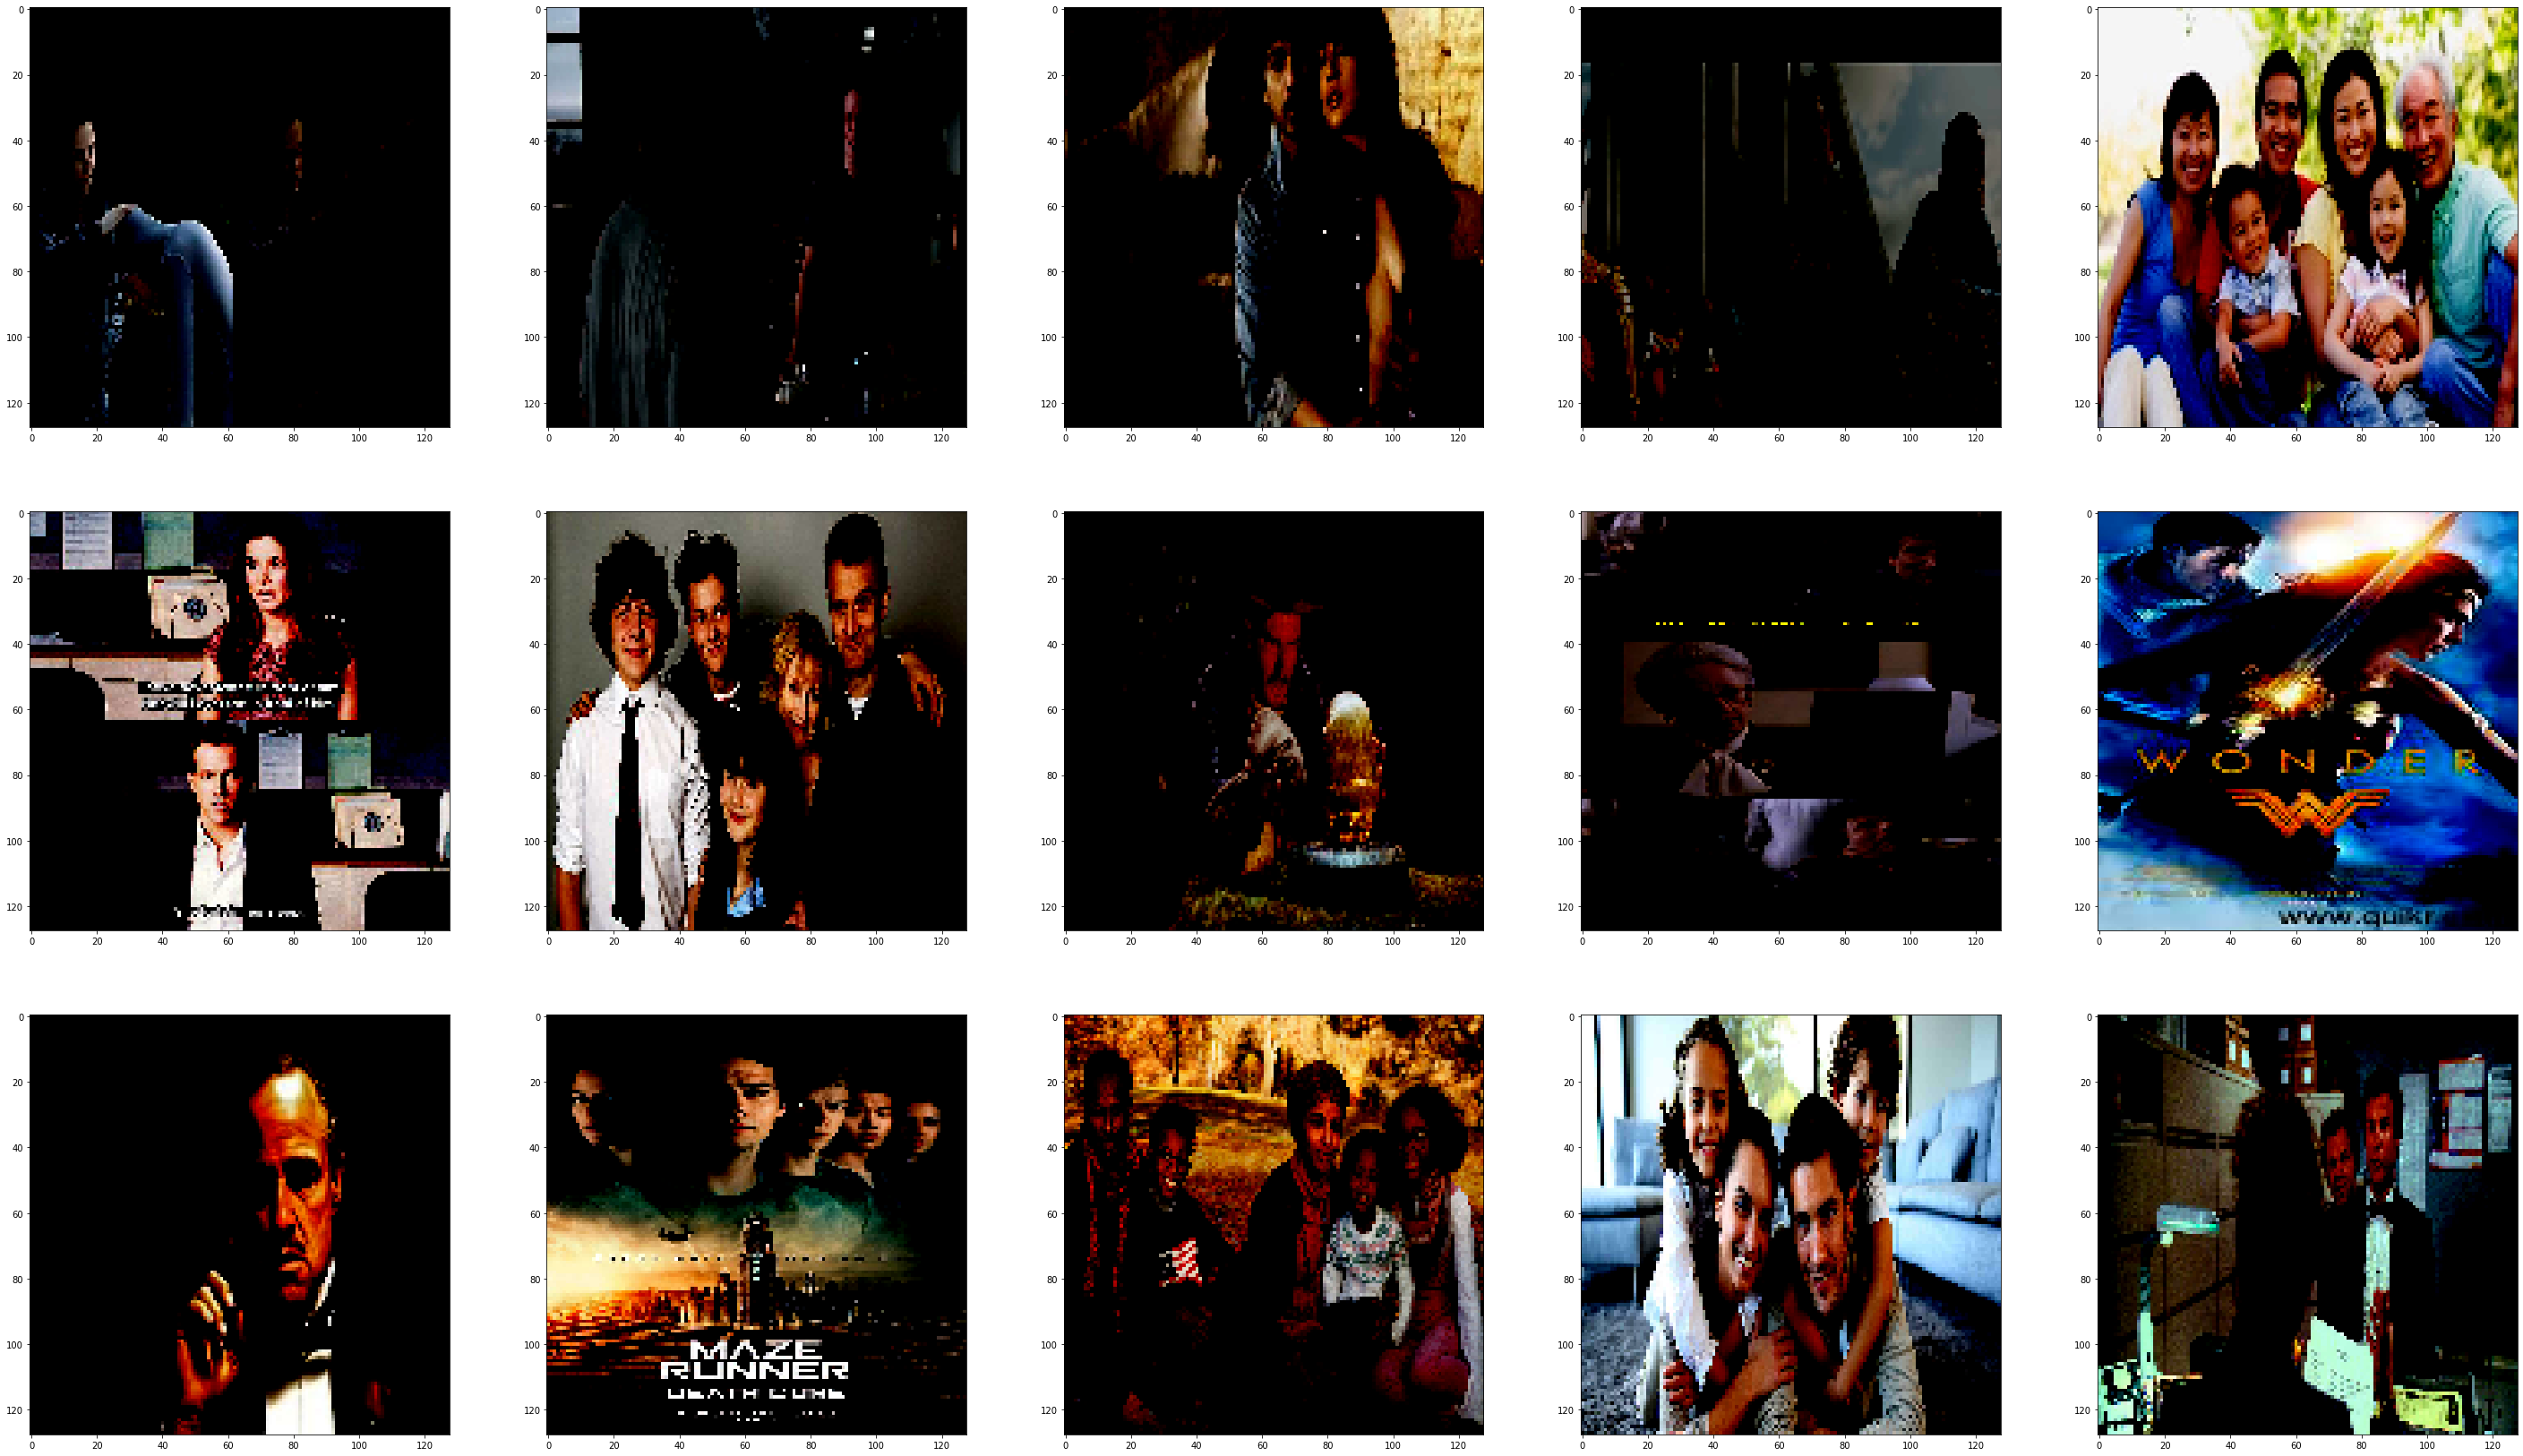

In [11]:
plt.figure(figsize = (50,50)) 
random(images)

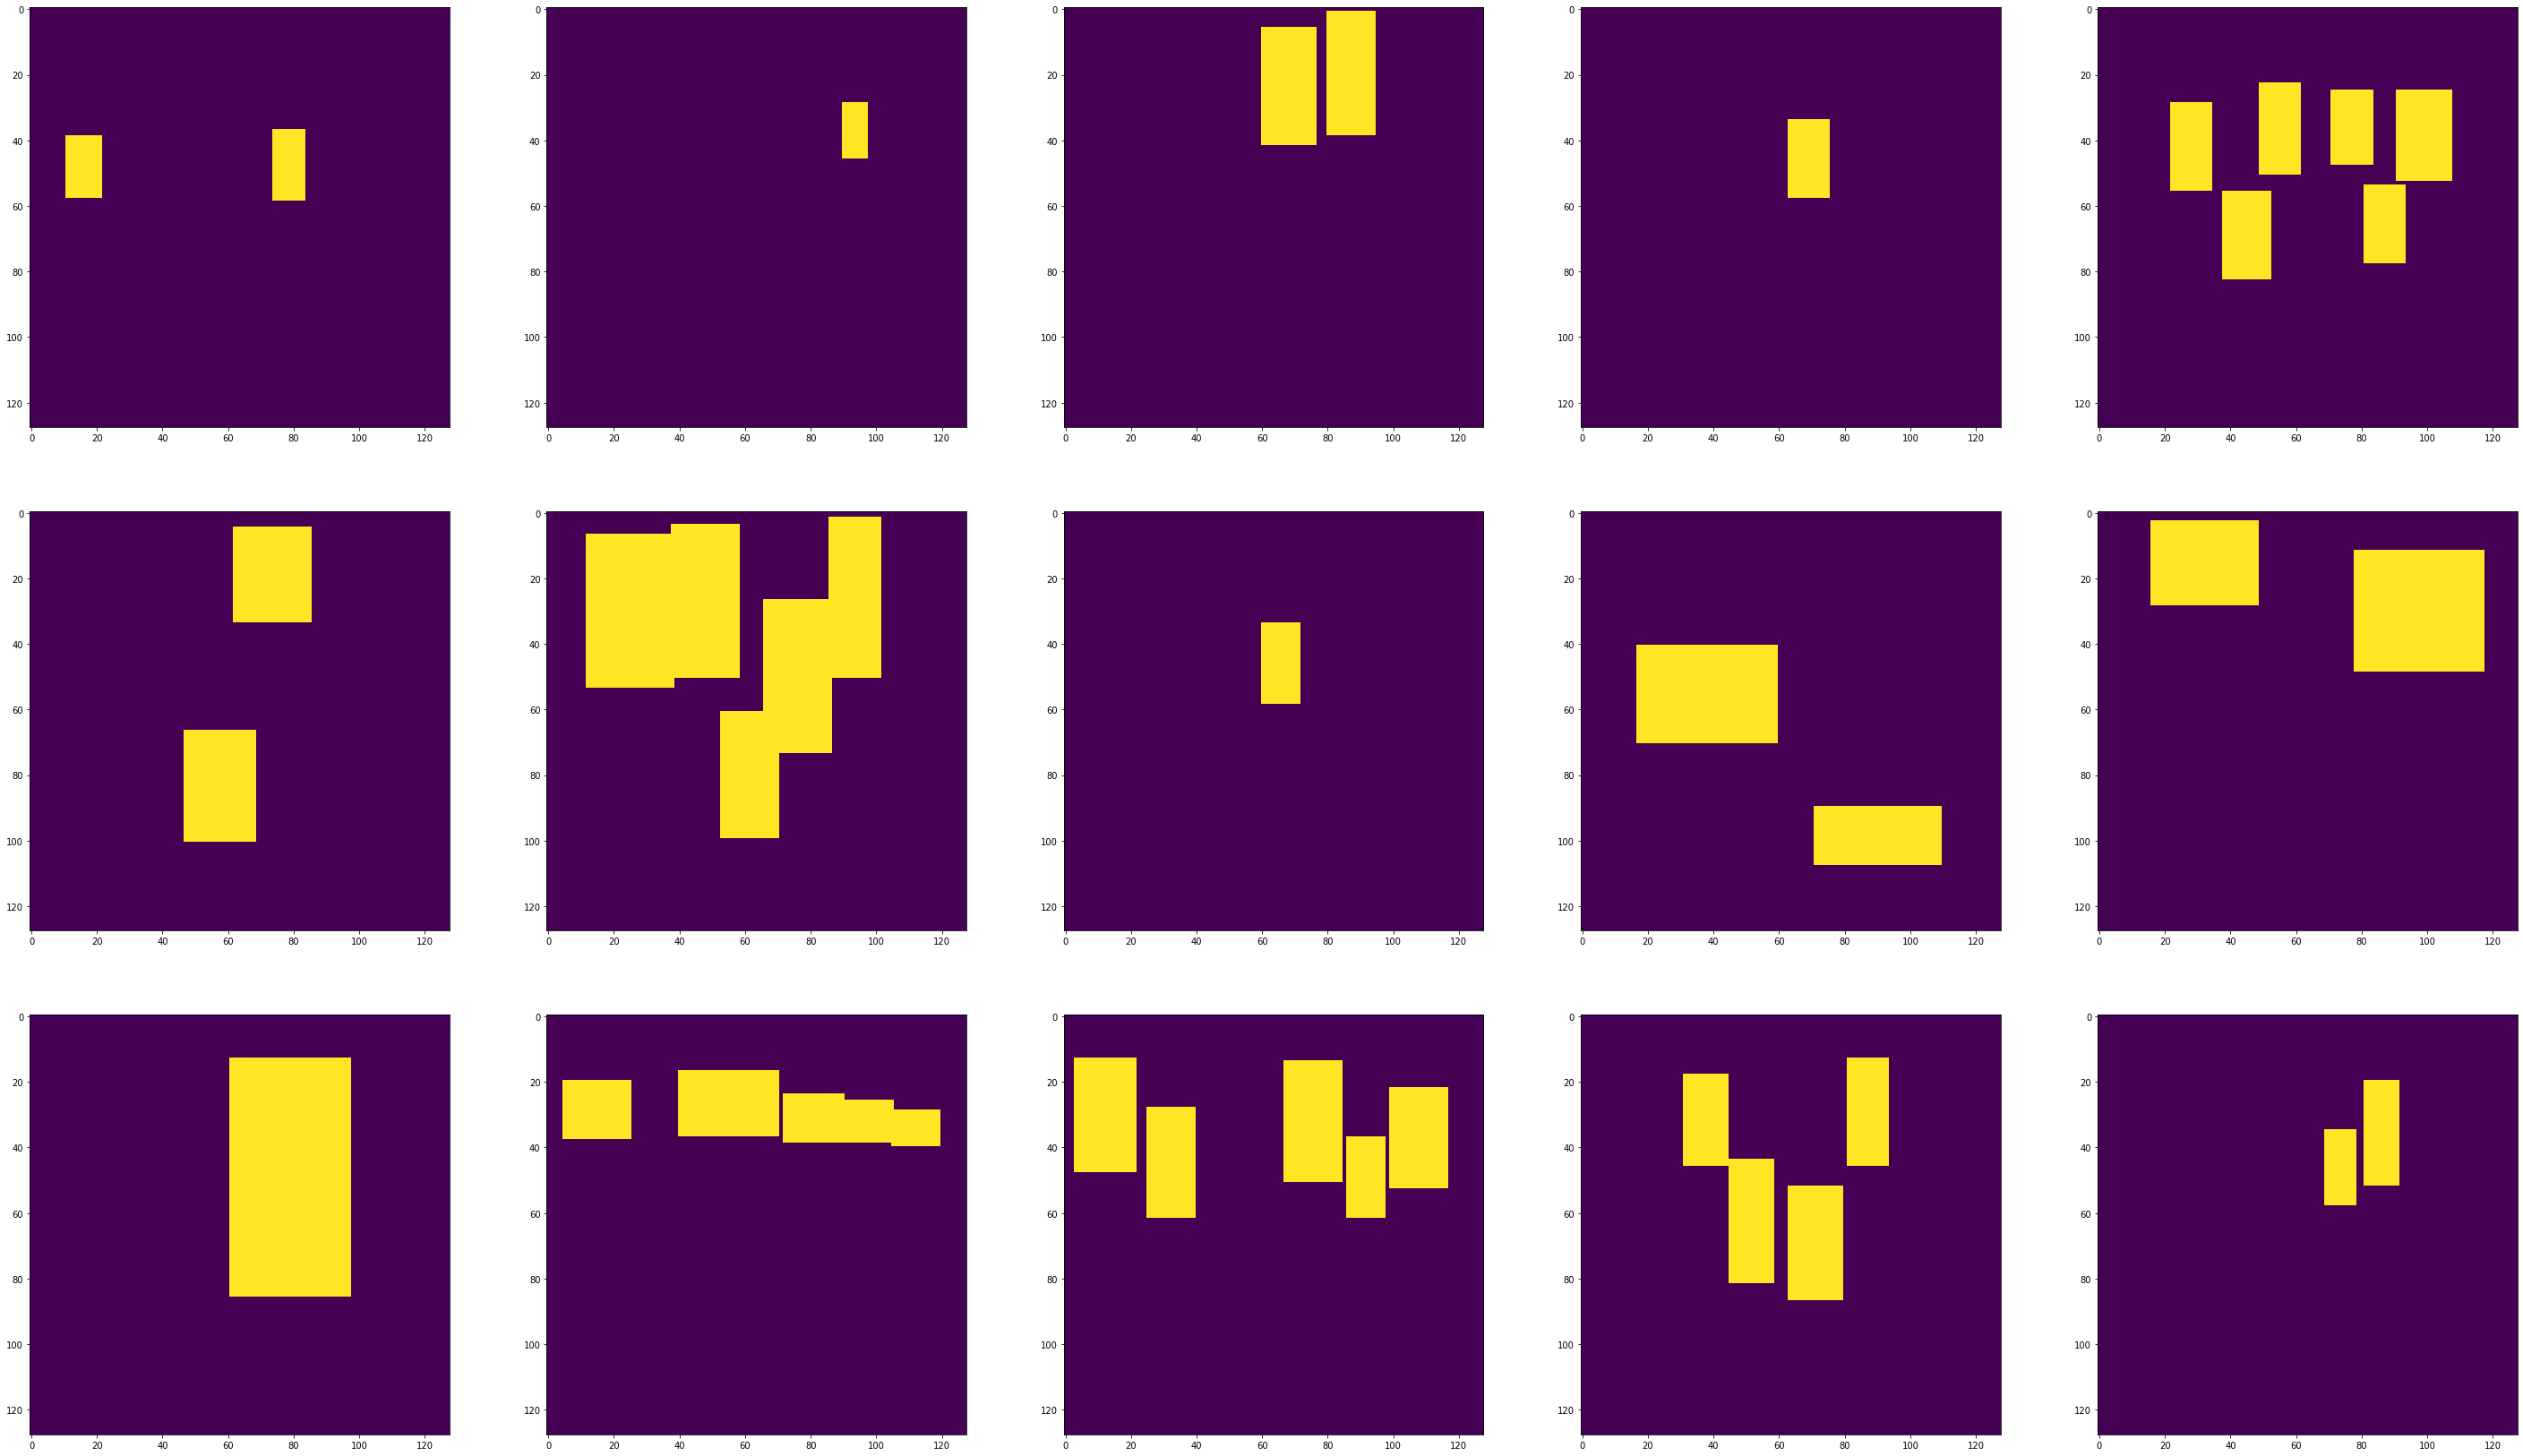

In [12]:
plt.figure(figsize = (50,50)) 
random(masks)

<font size="5"><p style="color:black"> <b>3. Mask detection model </p></font>

**A. Design a face mask detection model.**

 *Hint: Use U-net along with pre-trained transfer learning models* 

Inserting the path into system

In [13]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/')

Importing custom model

In [14]:
from Unet_Model import *

Defining the input shape and output shape

In [78]:
image_height = 128
image_width = 128
image_size = 128
channel = 3
ALPHA = 1

Defining the UNET model architecture




In [16]:
from tensorflow.keras import backend as K
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import UpSampling2D, Dense, Flatten, Input, Activation,Concatenate, BatchNormalization,Reshape, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, LeakyReLU, SpatialDropout2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet import MobileNet

def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = strides, name = prefix + '_conv')(prevlayer)
    conv = BatchNormalization(name = prefix + 'BatchNormalization')(conv)
    conv = Activation('relu', name = prefix + 'ActivationLayer')(conv)
    return conv

def create_model(trainable = True):
    model = MobileNet(input_shape = (image_height, image_width, 3), include_top = False, alpha = ALPHA, weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = trainable
    
    block1 = model.get_layer('conv_pw_13_relu').output
    block2 = model.get_layer('conv_pw_11_relu').output
    block3 = model.get_layer('conv_pw_5_relu').output
    block4 = model.get_layer('conv_pw_3_relu').output
    block5 = model.get_layer('conv_pw_1_relu').output
    
    up1 = Concatenate()([UpSampling2D()(block1), block2])
    conv6 = conv_block_simple(up1, 256, 'Conv_6_1')
    conv6 = conv_block_simple(conv6, 256, 'Conv_6_2')

    up2 = Concatenate()([UpSampling2D()(conv6), block3])
    conv7 = conv_block_simple(up2, 256, 'Conv_7_1')
    conv7 = conv_block_simple(conv7, 256, 'Conv_7_2')

    up3 = Concatenate()([UpSampling2D()(conv7), block4])
    conv8 = conv_block_simple(up3, 192, 'Conv_8_1')
    conv8 = conv_block_simple(conv8, 128, 'Conv_8_2')

    up4 = Concatenate()([UpSampling2D()(conv8), block5])
    conv9 = conv_block_simple(up4, 96, 'Conv_9_1')
    conv9 = conv_block_simple(conv9, 64, 'Conv_9_2')

    up5 = Concatenate()([UpSampling2D()(conv9), model.input])
    conv10 = conv_block_simple(up5, 48, 'Conv_10_1')
    conv10 = conv_block_simple(conv10, 32, 'Conv_10_2')
    conv10 = SpatialDropout2D(0.2)(conv10)
    
    x = Conv2D(1, (1, 1), activation = 'sigmoid')(conv10)
    x = Reshape((image_size, image_size))(x)
    return Model(inputs = model.input, outputs = x)

In [17]:
model = create_model(True)

17235968/17225924 [==============================] - 0s 0us/step


Model Summary

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 32)   128         ['conv1[0][0]']                  
                                                                                                  
 conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['conv1_bn[0][0]']           

Displaying U-net Architecture

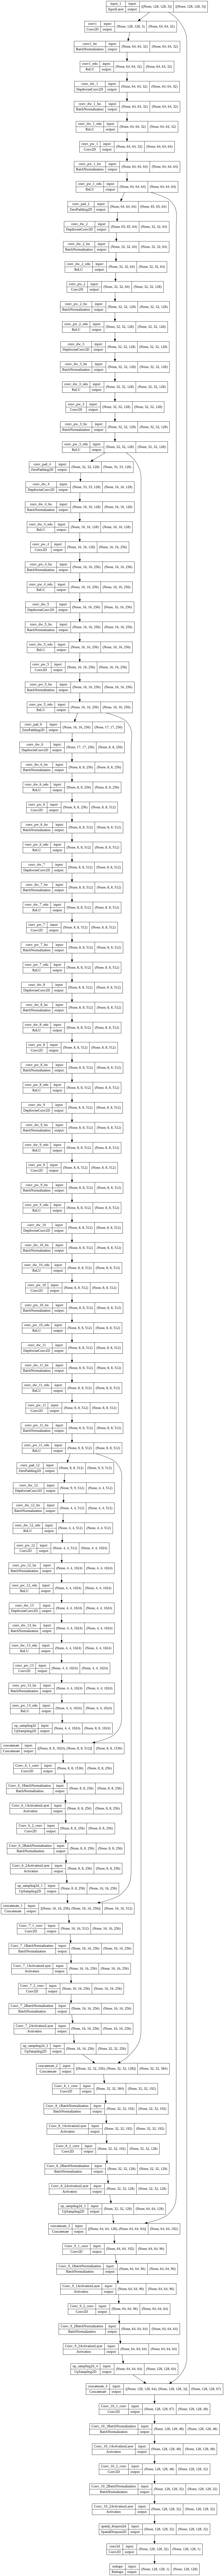

In [19]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='unet_structure.png',show_shapes=True, show_layer_names=True)

from IPython.display import Image as IP_Image
IP_Image(retina=True, filename='unet_structure.png')

Displaying unet trainable parameters



In [20]:
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
unet_model_df = pd.DataFrame(layers, columns=["Layer Type", "Layer Name", "Layer Trainable"])

display(unet_model_df)

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_1,True
1,<keras.layers.convolutional.Conv2D object at 0...,conv1,True
2,<keras.layers.normalization.batch_normalizatio...,conv1_bn,True
3,<keras.layers.advanced_activations.ReLU object...,conv1_relu,True
4,<keras.layers.convolutional.DepthwiseConv2D ob...,conv_dw_1,True
...,...,...,...
124,<keras.layers.normalization.batch_normalizatio...,Conv_10_2BatchNormalization,True
125,<keras.layers.core.activation.Activation objec...,Conv_10_2ActivationLayer,True
126,<keras.layers.core.spatial_dropout.SpatialDrop...,spatial_dropout2d,True
127,<keras.layers.convolutional.Conv2D object at 0...,conv2d,True


**B. Design your own Dice Coefficient and Loss function.**

Defining Dice Coefficient


In [21]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

Defining the loss function

In [22]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

**C. Train, tune and test the model**

In [23]:
images.shape

(409, 128, 128, 3)

In [24]:
masks.shape

(409, 128, 128)

Defining adamn optimizer parameters and compliling 

In [25]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
adam = Adam(learning_rate = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
model.compile(loss = loss, optimizer = adam, metrics = [dice_coefficient])

Predefining callbacks

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint('model_{loss:.2f}.h5', monitor = 'loss', verbose = 1, save_best_only = True, save_weights_only = True, mode = 'min', period = 1)
stop = EarlyStopping(monitor = 'loss', patience = 5, mode = 'min')
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, min_lr = 1e-6, verbose = 1, mode = 'min')


Splitting dataset (masks, images) into 80:20 and into train and test

In [27]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size = 0.20, random_state = 12, shuffle = False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((327, 128, 128, 3), (82, 128, 128, 3), (327, 128, 128), (82, 128, 128))

training the model for facial recognition

In [28]:
model.fit(X_train, y_train, epochs = 20, batch_size = 1, callbacks = [checkpoint, reduce_lr, stop], validation_data = (X_test, y_test))

Epoch 1/20
327/327 [==============================] - ETA: 0s - loss: 1.6460 - dice_coefficient: 0.3774
Epoch 1: loss improved from inf to 1.64600, saving model to model_1.65.h5
327/327 [==============================] - 230s 689ms/step - loss: 1.6460 - dice_coefficient: 0.3774 - val_loss: 1.3557 - val_dice_coefficient: 0.3964 - lr: 1.0000e-04
Epoch 2/20
327/327 [==============================] - ETA: 0s - loss: 1.1661 - dice_coefficient: 0.4767
Epoch 2: loss improved from 1.64600 to 1.16612, saving model to model_1.17.h5
327/327 [==============================] - 223s 683ms/step - loss: 1.1661 - dice_coefficient: 0.4767 - val_loss: 1.3806 - val_dice_coefficient: 0.3648 - lr: 1.0000e-04
Epoch 3/20
327/327 [==============================] - ETA: 0s - loss: 0.9401 - dice_coefficient: 0.5456
Epoch 3: loss improved from 1.16612 to 0.94005, saving model to model_0.94.h5
327/327 [==============================] - 224s 686ms/step - loss: 0.9401 - dice_coefficient: 0.5456 - val_loss: 1.1129 - 

**D. Evaluate the model using testing data**



Evaluating the model for accuracy

In [30]:
model.evaluate(X_test, y_test, verbose = 1)

3/3 [==============================] - 12s 3s/step - loss: 0.9250 - dice_coefficient: 0.5834


[0.9250495433807373, 0.5833958983421326]

* Test accuracy of 58.3 % while train accuracy of 92.5%

Defining the y_pred from the model for further prediction

In [205]:
# Load previous model weight
WEIGHTS_FILE = "model_0.16.h5"
learned_model = create_model()
learned_model.load_weights(WEIGHTS_FILE)
y_pred = learned_model.predict(X_test, verbose = 1)

3/3 [==============================] - 12s 3s/step


Testing the facial detection by taking a sample image from the test dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


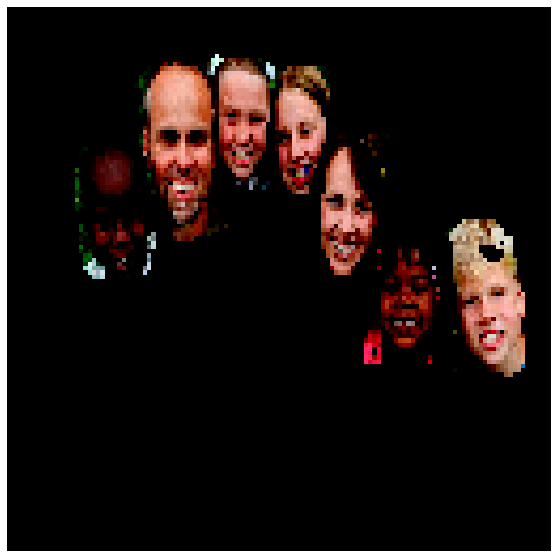

In [206]:
# For a sample image
n = 48
image = cv2.resize(X_test[n], dsize = (image_height, image_width), interpolation = cv2.INTER_CUBIC)
pred_mask = cv2.resize(1.0*(y_pred[n] > 0.1), (image_width, image_height))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]
out_image = image2
  
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(out_image)

In [207]:
print(image.shape,'\n\n',pred_mask.shape,'\n\n', out_image.shape)

(128, 128, 3) 

 (128, 128) 

 (128, 128, 3)


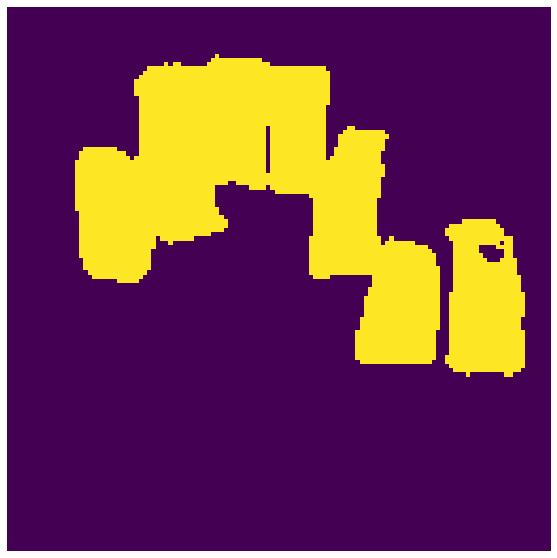

In [208]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(pred_mask, alpha = 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


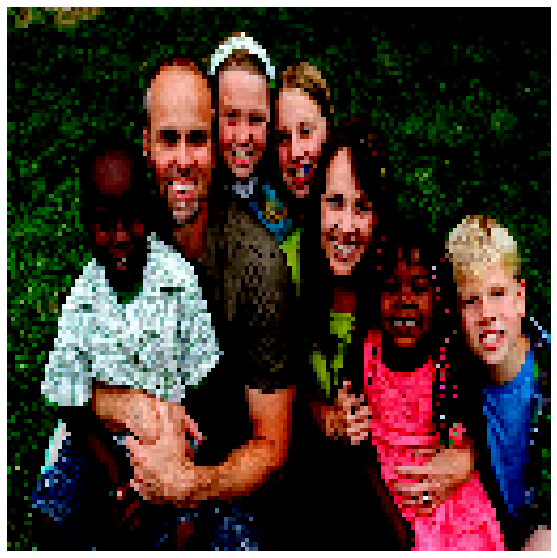

In [209]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(X_test[n])
plt.savefig('image.jpg', bbox_inches = 'tight', pad_inches = 0)

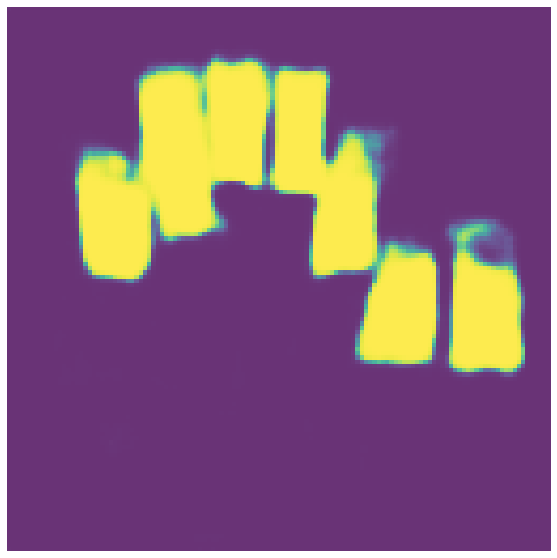

In [210]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(y_pred[n], alpha = 0.8)
plt.savefig('mask.jpg', bbox_inches = 'tight', pad_inches = 0)

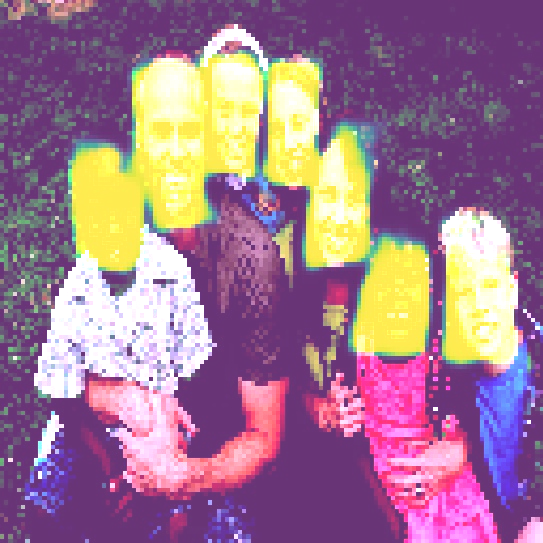

In [211]:
from google.colab.patches import cv2_imshow
img = cv2.imread('image.jpg', 1)
mask = cv2.imread('mask.jpg', 1)
img = cv2.add(img, mask)
cv2_imshow(img)

* The model is accurately detecting the faces in the image, hence we can conclude that the face detection model is working good with test dataset

<font size="5"><p style="color:black"> <b>4. Use the “Prediction image” as an input to your designed model and display the output of the image </p></font>

In [290]:
from google.colab.patches import cv2_imshow
img_pred = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Part 1Test Data - Prediction Image.jpeg')

In [291]:
img_pred.shape

(500, 500, 3)

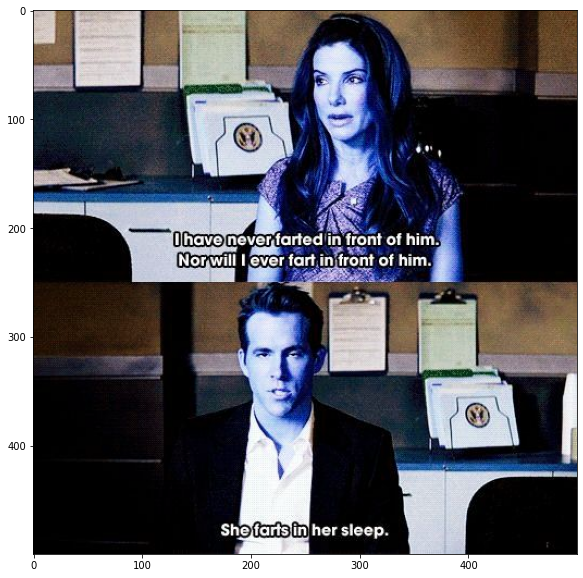

In [292]:
plt.figure(figsize = (10,10))
plt.imshow(img_pred)

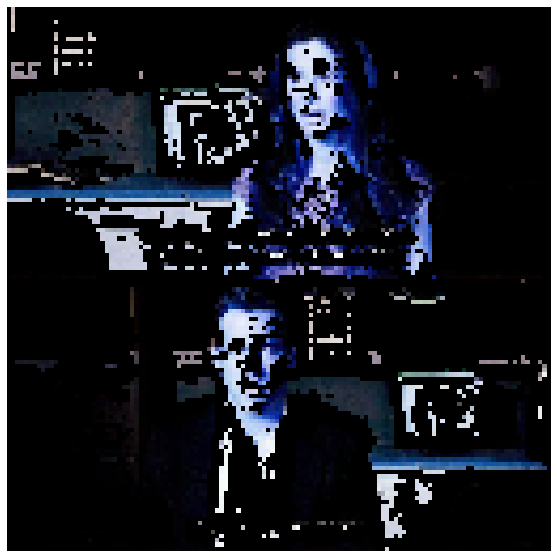

In [294]:
import matplotlib.pyplot as plt
filename = '/content/drive/MyDrive/Colab Notebooks/Part 1Test Data - Prediction Image.jpeg'

unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (image_width1, image_height1))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(learned_model.predict(x=np.array([feat_scaled]))[0] > 0.6), (image_width1,image_height1))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(out_image)

* From the above image, we can see that the facial detection model is not accurate, however, it had good prediction in test dataset. This could be an imperfect code or could be result of low validation accuracy 